Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [7]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [17]:
def sgd(train_dataset, train_labels,
        graph, tf_train_dataset, tf_train_labels, loss, optimizer, 
        train_prediction, valid_prediction, test_prediction, 
        num_steps, batch_size):
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        #if (step % 500 == 0):
        if (step % (num_steps / 10) == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [11]:
def buildLogitGraph(batch_size, L2):
    graph = tf.Graph()
    
    with graph.as_default():

        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        
        
        weigths_reg = tf.nn.l2_loss(weights)
        loss += L2 * weigths_reg


        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
        
    return (graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction)

In [18]:
batch_size = 128
num_steps = 3001
L2 = 0.001

graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction = buildLogitGraph(batch_size, L2)
sgd(train_dataset, train_labels, graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction, num_steps, batch_size)

Initialized
Minibatch loss at step 0: 20.574633
Minibatch accuracy: 14.8%
Validation accuracy: 13.0%
Minibatch loss at step 300: 3.222669
Minibatch accuracy: 78.1%
Validation accuracy: 74.3%
Minibatch loss at step 600: 2.211491
Minibatch accuracy: 80.5%
Validation accuracy: 76.3%
Minibatch loss at step 900: 1.542102
Minibatch accuracy: 82.0%
Validation accuracy: 77.2%
Minibatch loss at step 1200: 1.481816
Minibatch accuracy: 73.4%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 1.177761
Minibatch accuracy: 80.5%
Validation accuracy: 79.5%
Minibatch loss at step 1800: 0.948772
Minibatch accuracy: 83.6%
Validation accuracy: 80.5%
Minibatch loss at step 2100: 0.996795
Minibatch accuracy: 77.3%
Validation accuracy: 80.3%
Minibatch loss at step 2400: 0.900701
Minibatch accuracy: 79.7%
Validation accuracy: 81.3%
Minibatch loss at step 2700: 0.773153
Minibatch accuracy: 84.4%
Validation accuracy: 81.9%
Minibatch loss at step 3000: 0.766949
Minibatch accuracy: 81.2%
Validation accuracy

In [13]:
def buildOneHiddenNNGraph(batch_size, hidden_nodes, L2):
    one_hidden_layer_graph = tf.Graph()
    with one_hidden_layer_graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.

        # First Layer
        weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
        biases1 = tf.Variable(tf.zeros([hidden_nodes]))

        # Activation of First Layer
        a1 = tf.matmul(tf_train_dataset, weights1) + biases1

        # RELu
        relu = tf.nn.relu(a1)
        
        # Hidden Layer
        weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
        biases2 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits = tf.matmul(relu, weights2) + biases2
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        
        # L2 Regularization
        weigths1_reg = tf.nn.l2_loss(weights1)
        weights2_reg = tf.nn.l2_loss(weights2)
        
        loss += L2 * weigths1_reg
        loss += L2 * weights2_reg

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)

        # Validation
        valid_a1 = tf.matmul(tf_valid_dataset, weights1) + biases1
        valid_relu = tf.nn.relu(valid_a1)
        valid_prediction = tf.nn.softmax(tf.matmul(valid_relu, weights2) + biases2)

        # Test
        test_a1 = tf.matmul(tf_test_dataset, weights1) + biases1
        test_relu = tf.nn.relu(test_a1)
        test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights2) + biases2)
    
    return (one_hidden_layer_graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction)   


In [14]:
hidden_nodes = 1024
batch_size = 128
num_steps = 3001
L2 = 0.001

graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction = buildOneHiddenNNGraph(batch_size, hidden_nodes, L2)
sgd(train_dataset, train_labels, graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction, num_steps, batch_size)

Initialized
Minibatch loss at step 0: 606.954163
Minibatch accuracy: 10.2%
Validation accuracy: 29.1%
Minibatch loss at step 300: 234.043777
Minibatch accuracy: 85.9%
Validation accuracy: 80.3%
Minibatch loss at step 600: 173.837418
Minibatch accuracy: 82.8%
Validation accuracy: 79.1%
Minibatch loss at step 900: 126.945679
Minibatch accuracy: 84.4%
Validation accuracy: 80.3%
Minibatch loss at step 1200: 92.697968
Minibatch accuracy: 82.0%
Validation accuracy: 80.7%
Minibatch loss at step 1500: 68.705315
Minibatch accuracy: 85.2%
Validation accuracy: 82.5%
Minibatch loss at step 1800: 50.409191
Minibatch accuracy: 89.8%
Validation accuracy: 83.3%
Minibatch loss at step 2100: 37.588554
Minibatch accuracy: 84.4%
Validation accuracy: 84.5%
Minibatch loss at step 2400: 27.873928
Minibatch accuracy: 86.7%
Validation accuracy: 85.5%
Minibatch loss at step 2700: 20.693211
Minibatch accuracy: 89.1%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 15.457846
Minibatch accuracy: 85.9%
Valid

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [32]:
small_train_num = 1000
small_train_dataset = train_dataset[:small_train_num]
small_train_labels = train_labels[:small_train_num]

hidden_nodes = 1024
batch_size = 100
num_steps = 101
L2 = 0

graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction = buildOneHiddenNNGraph(batch_size, hidden_nodes, L2)
sgd(small_train_dataset, small_train_labels, graph, tf_train_dataset, tf_train_labels, loss, optimizer, train_prediction, valid_prediction, test_prediction, num_steps, batch_size)

Initialized
Minibatch loss at step 0: 298.214325
Minibatch accuracy: 12.0%
Validation accuracy: 24.2%
Minibatch loss at step 10: 96.382179
Minibatch accuracy: 70.0%
Validation accuracy: 73.0%
Minibatch loss at step 20: 11.613085
Minibatch accuracy: 90.0%
Validation accuracy: 74.3%
Minibatch loss at step 30: 16.331694
Minibatch accuracy: 92.0%
Validation accuracy: 75.7%
Minibatch loss at step 40: 4.388021
Minibatch accuracy: 96.0%
Validation accuracy: 75.7%
Minibatch loss at step 50: 0.720822
Minibatch accuracy: 98.0%
Validation accuracy: 76.0%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.3%
Minibatch loss at step 70: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.3%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Minibatch loss at step 90: 0.000051
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [33]:
def sgd_with_dropout(train_dataset, train_labels,
                     graph, tf_train_dataset, tf_train_labels, loss, optimizer, 
        train_prediction, valid_prediction, test_prediction, num_steps, batch_size, 
        tf_dropout, dropout_prob):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_dropout : dropout_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            #if (step % 500 == 0):
            if (step % (num_steps / 10) == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))

                # Don't dropout
                valid_feed_dict = {tf_dropout : 1.0}
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(feed_dict=valid_feed_dict), valid_labels))

        # Don't dropout
        test_feed_dict = {tf_dropout : 1.0}
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict=test_feed_dict), test_labels))

In [34]:
def buildOneHiddenNNGraph_with_dropout(batch_size, hidden_nodes, L2):
    one_hidden_layer_graph = tf.Graph()
    with one_hidden_layer_graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.

        # First Layer
        weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
        biases1 = tf.Variable(tf.zeros([hidden_nodes]))

        # Activation of First Layer
        a1 = tf.matmul(tf_train_dataset, weights1) + biases1

        # RELu
        relu = tf.nn.relu(a1)
        
        # Dropout
        # Using placeholder allow us to use Dropout only during Training process (not Evaluating)
        tf_dropout = tf.placeholder(tf.float32)
        dropout = tf.nn.dropout(relu, tf_dropout)

        # Hidden Layer
        weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
        biases2 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits = tf.matmul(dropout, weights2) + biases2
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        
        # L2 Regularization
        weigths1_reg = tf.nn.l2_loss(weights1)
        weights2_reg = tf.nn.l2_loss(weights2)
        
        loss += L2 * weigths1_reg
        loss += L2 * weights2_reg

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)

        # Validation
        valid_a1 = tf.matmul(tf_valid_dataset, weights1) + biases1
        valid_relu = tf.nn.relu(valid_a1)
        valid_prediction = tf.nn.softmax(tf.matmul(valid_relu, weights2) + biases2)

        # Test
        test_a1 = tf.matmul(tf_test_dataset, weights1) + biases1
        test_relu = tf.nn.relu(test_a1)
        test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights2) + biases2)
    
    return (one_hidden_layer_graph, tf_train_dataset, tf_train_labels, tf_dropout,
            loss, optimizer, train_prediction, valid_prediction, test_prediction)   


In [35]:
hidden_nodes = 1024
batches_num = 100
batch_size = 128#train_dataset.shape[0] / batches_num
num_steps = 3001
L2 = 0.001
dropout = 0.5

graph, tf_train_dataset, tf_train_labels, tf_dropout, loss, optimizer, train_prediction, valid_prediction, test_prediction = buildOneHiddenNNGraph_with_dropout(batch_size, hidden_nodes, L2)

sgd_with_dropout(train_dataset, train_labels, graph, tf_train_dataset, tf_train_labels, loss, optimizer, 
                 train_prediction, valid_prediction, test_prediction, num_steps, batch_size,
                tf_dropout, dropout)

Initialized
Minibatch loss at step 0: 788.572876
Minibatch accuracy: 13.3%
Validation accuracy: 23.9%
Minibatch loss at step 300: 240.957367
Minibatch accuracy: 77.3%
Validation accuracy: 80.5%
Minibatch loss at step 600: 186.304520
Minibatch accuracy: 74.2%
Validation accuracy: 79.5%
Minibatch loss at step 900: 129.192978
Minibatch accuracy: 74.2%
Validation accuracy: 80.9%
Minibatch loss at step 1200: 94.336266
Minibatch accuracy: 78.1%
Validation accuracy: 80.4%
Minibatch loss at step 1500: 69.613640
Minibatch accuracy: 77.3%
Validation accuracy: 81.5%
Minibatch loss at step 1800: 51.091213
Minibatch accuracy: 85.2%
Validation accuracy: 82.6%
Minibatch loss at step 2100: 37.907959
Minibatch accuracy: 78.1%
Validation accuracy: 83.6%
Minibatch loss at step 2400: 27.931246
Minibatch accuracy: 82.0%
Validation accuracy: 84.2%
Minibatch loss at step 2700: 20.670872
Minibatch accuracy: 85.2%
Validation accuracy: 85.0%
Minibatch loss at step 3000: 15.523764
Minibatch accuracy: 82.0%
Valid

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [7]:
from mln import MultiLayerNet, Solver

In [8]:
input_dim = image_size * image_size
hidden_dims = [1024, 300, 50]
num_classes = num_labels
batches_num = 100
batch_size = train_dataset.shape[0] / batches_num

In [189]:
#Find best weight scale

num_epochs = 10
dropout_prob = 0.5

l2 = 0
weight_scales = np.logspace(-4, 0, num=5)
lr_start = 1e-4
lr_decay_steps = 100000
lr_decay_rate = 0.96

best_valid_loss = 0
best_valid_accuracy = 0
best_valid_weights = None
best_valid_biases = None
best_valid_ws = 0

best_valid_loss_history = []
best_valid_accs_history = []

for i, weight_scale in enumerate(weight_scales):
    print ('-----------------------------------------')
    print ('Start NN l2 %e weight_scale %e ' % (l2, weight_scale))

    mln = MultiLayerNet(input_dim, hidden_dims, num_classes, l2)
    solver = Solver(mln, train_dataset, train_labels, valid_dataset, valid_labels, 
                    batch_size, num_epochs, dropout_prob, 
                   lr_start, lr_decay_steps, lr_decay_rate)
    (valid_loss, valid_accuracy, valid_weights, valid_biases) = solver.train()

    best_valid_loss_history.append(valid_loss)
    best_valid_accs_history.append(valid_accuracy)

    if valid_accuracy > best_valid_accuracy:
        best_valid_loss = valid_loss
        best_valid_accuracy = valid_accuracy
        best_valid_weights = valid_weights
        best_valid_biases = valid_biases
        best_valid_ws = weight_scale

        
print("*************** Finished ***************")
print("Best Valid Accuracy: %.1f%% on L2: %e, WeightScale: %e -----------------" % (best_valid_accuracy*100, l2, best_valid_ws))

test_accuracy_model = MultiLayerNet(input_dim, hidden_dims, num_classes, l2, best_valid_ws, best_valid_weights, best_valid_biases)
with tf.Session(graph=test_accuracy_model.graph) as session:
    session.run(tf.initialize_all_variables())
    test_accuracy = test_accuracy_model.accuracy.eval(feed_dict={test_accuracy_model.X:test_dataset, 
                                                             test_accuracy_model.Y:test_labels, 
                                                             test_accuracy_model.dropout: 1.0})
print("*************** Test accuracy: %.1f%% *****************" % (test_accuracy*100))



-----------------------------------------
Start NN l2 0.000000e+00 weight_scale 1.000000e-04 
Initialized
------------------- Epoch 0 of 10 ----------------------
Minibatch loss: 5.631177
Minibatch train accuracy: 11.2%
Validation accuracy: 11.1%
------------------- Epoch 1 of 10 ----------------------
Minibatch loss: 2.035229
Minibatch train accuracy: 57.3%
Validation accuracy: 58.7%
------------------- Epoch 2 of 10 ----------------------
Minibatch loss: 1.517480
Minibatch train accuracy: 75.8%
Validation accuracy: 75.3%
------------------- Epoch 3 of 10 ----------------------
Minibatch loss: 1.325798
Minibatch train accuracy: 77.9%
Validation accuracy: 78.6%
------------------- Epoch 4 of 10 ----------------------
Minibatch loss: 1.159116
Minibatch train accuracy: 79.5%
Validation accuracy: 80.0%
------------------- Epoch 5 of 10 ----------------------
Minibatch loss: 1.021176
Minibatch train accuracy: 80.5%
Validation accuracy: 80.7%
------------------- Epoch 6 of 10 --------------

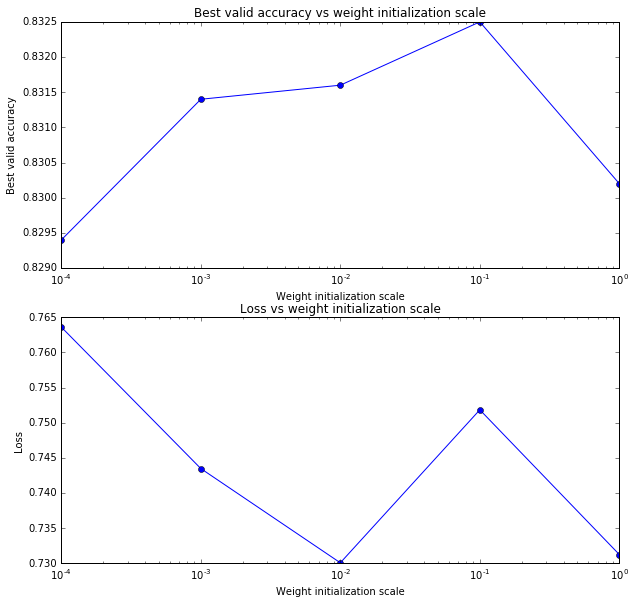

In [190]:
plt.subplot(3, 1, 1)
plt.title('Best valid accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best valid accuracy')
plt.semilogx(weight_scales, best_valid_accs_history, '-o', label='baseline')

plt.subplot(3, 1, 2)
plt.title('Loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Loss')
plt.semilogx(weight_scales, best_valid_loss_history, '-o')


plt.gcf().set_size_inches(10, 15)
plt.show()

In [211]:
#Find best L2 value

hidden_dims = [1024, 300, 50]
#hidden_dims = [4096, 2048, 1024]
batches_num = 100
batch_size = 1024#train_dataset.shape[0] / batches_num

num_epochs = 10
dropout_prob = 0.5

l2_strengths = np.logspace(-5, -4, num=2)
#l2_strengths = [0.001]
lr_start = 1e-3
lr_decay_steps = 100000
lr_decay_rate = 0.96

best_valid_l2_loss = 0
best_valid_l2_accuracy = 0
best_valid_l2_weights = None
best_valid_l2_biases = None
best_valid_l2_val = 0

best_valid_l2_loss_history = []
best_valid_l2_accs_history = []

for l2 in l2_strengths:
    
    print ('-----------------------------------------')
    print ('Start NN l2 %e weight_scale %e ' % (l2, best_valid_ws))

    mln = MultiLayerNet(input_dim, hidden_dims, num_classes, l2)
    solver = Solver(mln, train_dataset, train_labels, valid_dataset, valid_labels, 
                    batch_size, num_epochs, dropout_prob, 
                    lr_start, lr_decay_steps, lr_decay_rate)
    (valid_loss, valid_accuracy, valid_weights, valid_biases) = solver.train()

    best_valid_l2_loss_history.append(valid_loss)
    best_valid_l2_accs_history.append(valid_accuracy)

    if valid_accuracy > best_valid_l2_accuracy:
        best_valid_l2_loss = valid_loss
        best_valid_l2_accuracy = valid_accuracy
        best_valid_l2_weights = valid_weights
        best_valid_l2_biases = valid_biases
        best_valid_l2_val = l2

        
print("*************** Finished ***************")
print("Best Valid Accuracy: %.1f%% on L2: %e, WeightScale: %e -----------------" % (best_valid_l2_accuracy*100, 
                                                                                    best_valid_l2_val, best_valid_ws))

test_accuracy_model = MultiLayerNet(input_dim, hidden_dims, num_classes,
                                    best_valid_l2_val, best_valid_ws, best_valid_l2_weights, best_valid_l2_biases)
with tf.Session(graph=test_accuracy_model.graph) as session:
    session.run(tf.initialize_all_variables())
    test_accuracy = test_accuracy_model.accuracy.eval(feed_dict={test_accuracy_model.X:test_dataset, 
                                                             test_accuracy_model.Y:test_labels, 
                                                             test_accuracy_model.dropout: 1.0})
print("*************** Test accuracy: %.1f%% *****************" % (test_accuracy*100))


-----------------------------------------
Start NN l2 1.000000e-03 weight_scale 1.000000e-01 
Initialized
------------------- Epoch 0 of 10 ----------------------
Minibatch loss: 9.510757
Minibatch train accuracy: 22.0%
Validation accuracy: 22.4%
------------------- Epoch 1 of 10 ----------------------
Minibatch loss: 3.043007
Minibatch train accuracy: 83.7%
Validation accuracy: 83.9%
------------------- Epoch 2 of 10 ----------------------
Minibatch loss: 1.560463
Minibatch train accuracy: 87.2%
Validation accuracy: 85.3%
------------------- Epoch 3 of 10 ----------------------
Minibatch loss: 0.977196
Minibatch train accuracy: 86.9%
Validation accuracy: 86.1%
------------------- Epoch 4 of 10 ----------------------
Minibatch loss: 0.782926
Minibatch train accuracy: 87.2%
Validation accuracy: 86.7%
------------------- Epoch 5 of 10 ----------------------
Minibatch loss: 0.742308
Minibatch train accuracy: 87.5%
Validation accuracy: 87.0%
------------------- Epoch 6 of 10 --------------

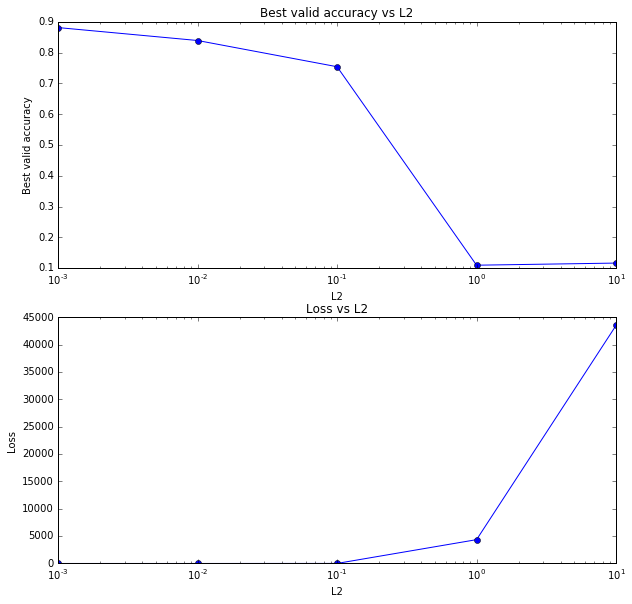

In [212]:
plt.subplot(3, 1, 1)
plt.title('Best valid accuracy vs L2')
plt.xlabel('L2')
plt.ylabel('Best valid accuracy')
plt.semilogx(l2_strengths, best_valid_l2_accs_history, '-o')


plt.subplot(3, 1, 2)
plt.title('Loss vs L2')
plt.xlabel('L2')
plt.ylabel('Loss')
plt.semilogx(l2_strengths, best_valid_l2_loss_history, '-o')


plt.gcf().set_size_inches(10, 15)
plt.show()

In [11]:
hidden_dims = [1024, 300, 50]
batches_num = 100
batch_size = 1024#train_dataset.shape[0] / batches_num

num_epochs = 500
dropout_prob = 0.5

l2 = 1e-3
lr_start = 1e-3
lr_decay_steps = 100000
lr_decay_rate = 0.96
ws = 0.1

print ('-----------------------------------------')
print ('Start NN l2 %e weight_scale %e ' % (l2, ws))

mln = MultiLayerNet(input_dim, hidden_dims, num_classes, l2)
solver = Solver(mln, train_dataset, train_labels, valid_dataset, valid_labels, 
                batch_size, num_epochs, dropout_prob, 
                lr_start, lr_decay_steps, lr_decay_rate)
(valid_loss, valid_accuracy, valid_weights, valid_biases) = solver.train()

print("*************** Finished ***************")
print("Best Valid Accuracy: %.1f%% on L2: %e, WeightScale: %e -----------------" % (valid_accuracy*100, l2, ws))

test_accuracy_model = MultiLayerNet(input_dim, hidden_dims, num_classes, l2, ws, valid_weights, valid_biases)
with tf.Session(graph=test_accuracy_model.graph) as session:
    session.run(tf.initialize_all_variables())
    test_accuracy = test_accuracy_model.accuracy.eval(feed_dict={test_accuracy_model.X:test_dataset, 
                                                             test_accuracy_model.Y:test_labels, 
                                                             test_accuracy_model.dropout: 1.0})
print("*************** Test accuracy: %.1f%% *****************" % (test_accuracy*100))


-----------------------------------------
Start NN l2 1.000000e-03 weight_scale 1.000000e-01 
Initialized
------------------- Epoch 0 of 500 ----------------------
Minibatch loss: 9.958504
Minibatch train accuracy: 23.0%
Validation accuracy: 22.5%
------------------- Epoch 1 of 500 ----------------------
Minibatch loss: 3.064637
Minibatch train accuracy: 83.6%
Validation accuracy: 84.0%
------------------- Epoch 2 of 500 ----------------------
Minibatch loss: 1.609797
Minibatch train accuracy: 86.0%
Validation accuracy: 85.1%
------------------- Epoch 3 of 500 ----------------------
Minibatch loss: 1.012100
Minibatch train accuracy: 87.5%
Validation accuracy: 86.2%
------------------- Epoch 4 of 500 ----------------------
Minibatch loss: 0.794315
Minibatch train accuracy: 88.1%
Validation accuracy: 86.7%
------------------- Epoch 5 of 500 ----------------------
Minibatch loss: 0.715869
Minibatch train accuracy: 88.5%
Validation accuracy: 87.1%
------------------- Epoch 6 of 500 -------